In [19]:
!pip install torch_geometric

In [20]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
import networkx as nx


In [21]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from matplotlib.colors import Normalize
from matplotlib import cm


In [22]:

dataset = Planetoid(root="/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())
data = dataset[0]
print(f"Dataset: {dataset.name}")
print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges//2}, Features: {data.num_features}, Classes: {dataset.num_classes}")


Dataset: Cora
Nodes: 2708, Edges: 5278, Features: 1433, Classes: 7


Cora dataset

Dataset: Cora
Nodes: 2708, Edges: 5278, Features: 1433, Classes: 7


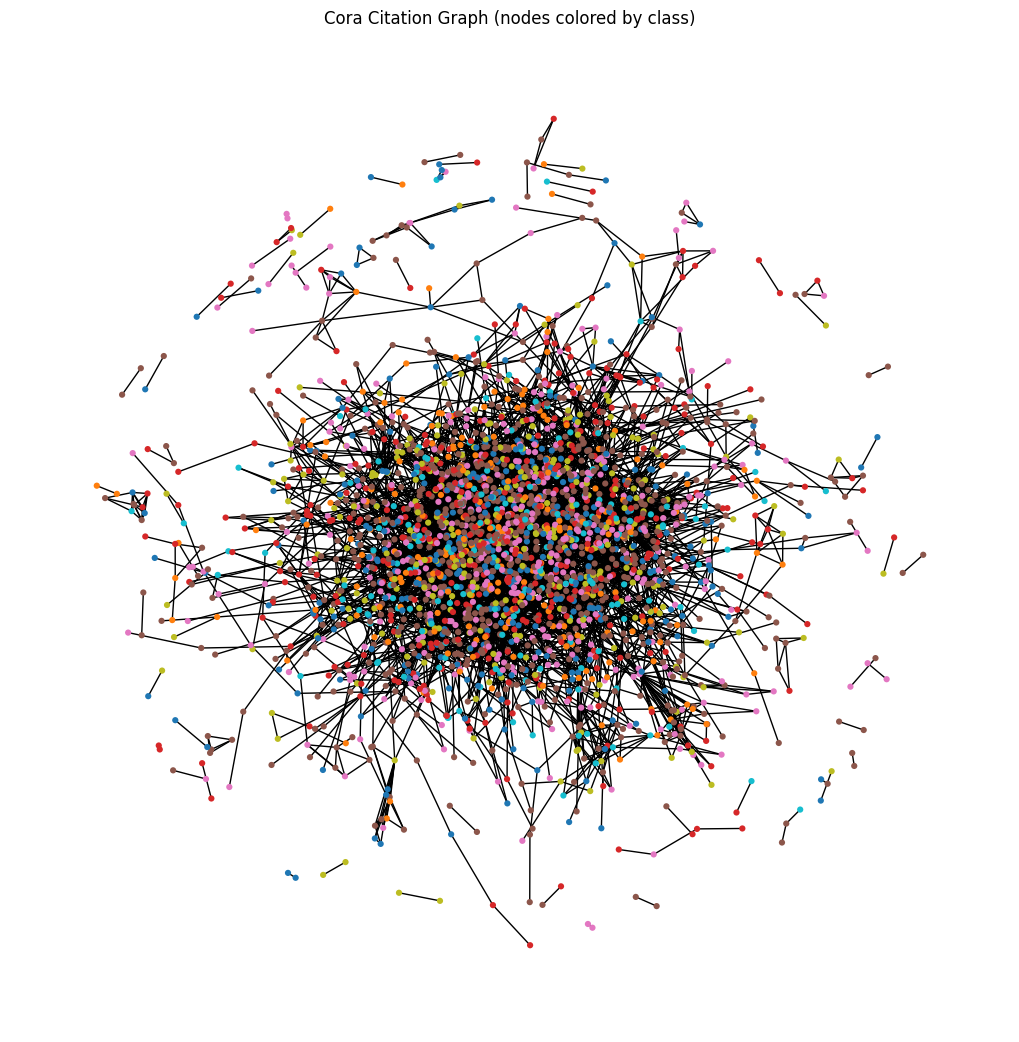

In [23]:
from torch_geometric.transforms import NormalizeFeatures
# Load Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

print(f"Dataset: {dataset.name}")
print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges // 2}, Features: {data.num_features}, Classes: {dataset.num_classes}")

# Convert to NetworkX
G = nx.Graph()
edge_index = data.edge_index.cpu().numpy()
G.add_edges_from(zip(edge_index[0], edge_index[1]))

# Node labels for coloring
y = data.y.cpu().numpy()

# Visualize (use sparse layout for speed)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42, k=0.1, iterations=30)  # k controls spacing
nx.draw(G, pos, node_color=y, cmap='tab10', node_size=20, linewidths=0, with_labels=False)
plt.title("Cora Citation Graph (nodes colored by class)")
plt.axis('off')
plt.show()

In [24]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

simple Forman curvature for each undirected edge

In [25]:
def forman_curvature(G):

    fc = {}
    for u, v in G.edges():
        triangles = len(list(nx.common_neighbors(G, u, v)))
        fc[(u, v)] = 4 - (G.degree[u] + G.degree[v]) + 3 * triangles
    return fc

G = to_networkx(data, to_undirected=True)
forman = forman_curvature(G)
values = np.array(list(forman.values()))
print(f"Forman curvature stats > min:{values.min():.2f}, mean:{values.mean():.2f}, max:{values.max():.2f}")


Forman curvature stats > min:-176.00, mean:-15.04, max:7.00


/tmp/ipython-input-3012770291.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


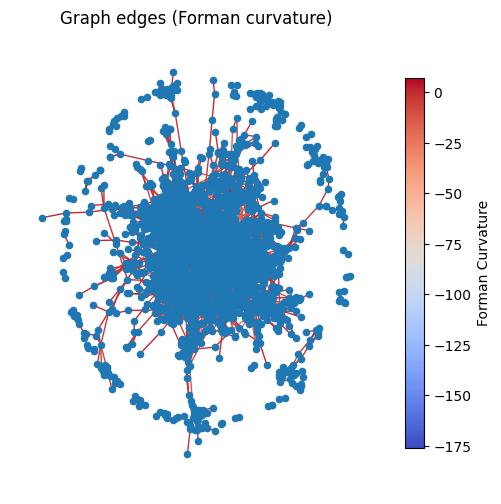

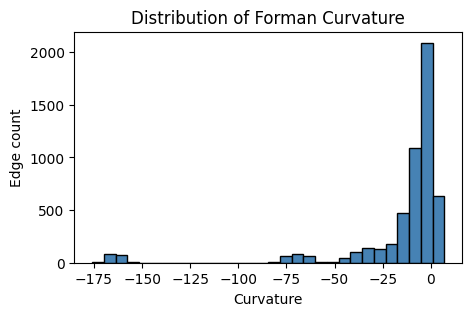

In [26]:
norm = Normalize(vmin=values.min(), vmax=values.max())
cmap = cm.get_cmap('coolwarm')
pos = nx.spring_layout(G, seed=42)
edge_colors = [cmap(norm(forman[(u, v)])) for u, v in G.edges()]

fig, ax = plt.subplots(figsize=(6, 6))
nx.draw(
    G,
    pos,
    node_size=20,
    edge_color=edge_colors,
    width=1.0,
    ax=ax,
    with_labels=False,
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label("Forman Curvature", fontsize=10)

ax.set_title("Graph edges (Forman curvature)")
plt.show()


plt.figure(figsize=(5, 3))
plt.hist(values, bins=30, color="steelblue", edgecolor="k")
plt.title("Distribution of Forman Curvature")
plt.xlabel("Curvature")
plt.ylabel("Edge count")
plt.show()


In [27]:

edges = data.edge_index.t().tolist()
weights = torch.tensor(
    [forman.get(tuple(sorted(e)), 0.0) for e in edges],
    dtype=torch.float
)

weights = (weights - weights.min()) / (weights.max() - weights.min() + 1e-9)
weights = 0.1 + 0.9 * weights      # to avoid zero weights
data.edge_weight = weights


In [28]:
class CurvatureGCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x


In [29]:
model = CurvatureGCN(dataset.num_features, 64, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_weight)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

def test():
    model.eval()
    out = model(data.x, data.edge_index, data.edge_weight)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append((pred[mask] == data.y[mask]).sum() / mask.sum())
    return accs, out

for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        accs, _ = test()
        print(f"Epoch {epoch:03d} | Loss {loss:.3f} | Train {accs[0]:.3f} | Val {accs[1]:.3f} | Test {accs[2]:.3f}")


Epoch 020 | Loss 1.372 | Train 0.971 | Val 0.758 | Test 0.785
Epoch 040 | Loss 0.638 | Train 0.971 | Val 0.798 | Test 0.820
Epoch 060 | Loss 0.391 | Train 0.993 | Val 0.786 | Test 0.813
Epoch 080 | Loss 0.292 | Train 0.993 | Val 0.802 | Test 0.823
Epoch 100 | Loss 0.252 | Train 1.000 | Val 0.794 | Test 0.809
Epoch 120 | Loss 0.199 | Train 1.000 | Val 0.802 | Test 0.807
Epoch 140 | Loss 0.200 | Train 1.000 | Val 0.798 | Test 0.815
Epoch 160 | Loss 0.178 | Train 1.000 | Val 0.794 | Test 0.803
Epoch 180 | Loss 0.169 | Train 1.000 | Val 0.798 | Test 0.802
Epoch 200 | Loss 0.170 | Train 1.000 | Val 0.796 | Test 0.807


t-sne visualization

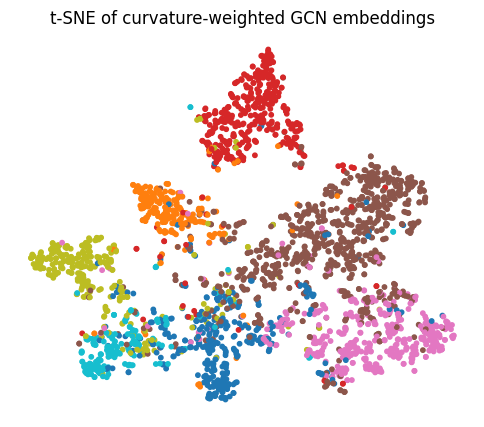

In [30]:
model.eval()
_, logits = test()
emb = logits.detach().cpu().numpy()
labels = data.y.cpu().numpy()


tsne = TSNE(n_components=2, random_state=42, perplexity=30)
z = tsne.fit_transform(emb)

plt.figure(figsize=(6, 5))
plt.scatter(z[:,0], z[:,1], c=labels, cmap='tab10', s=10)
plt.title("t-SNE of curvature-weighted GCN embeddings")
plt.axis('off')
plt.show()




---



---



In [31]:
try:
    import torch
    import torch.nn.functional as F
    from torch_geometric.nn import GCNConv
    from torch_geometric.utils import to_networkx, add_self_loops
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    from collections import defaultdict
except ImportError:
    !pip install torch_geometric -q
    import torch
    import torch.nn.functional as F
    from torch_geometric.nn import GCNConv
    from torch_geometric.utils import to_networkx, add_self_loops
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    from collections import defaultdict



# Experiment 1: Fixed Curvature Edge Weights



## Evaluate static Forman curvature as edge weights on homophilic (Cora) and heterophilic (Chameleon) graphs.

In [32]:
from torch_geometric.datasets import Planetoid, WikipediaNetwork
from torch_geometric.transforms import NormalizeFeatures

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def forman_curvature(G):

    fc = {}
    for u, v in G.edges():
        triangles = len(list(nx.common_neighbors(G, u, v)))
        degree_sum = G.degree[u] + G.degree[v]
        curvature = max(0.1, 4 - degree_sum + 3 * triangles)
        fc[(u, v)] = curvature
    return fc


In [33]:

def add_forman_edge_weights(data):
    import numpy as np
    from torch_geometric.utils import to_networkx


    G = to_networkx(data, to_undirected=True)


    forman = forman_curvature(G)

    edge_index = data.edge_index.cpu()
    num_edges = edge_index.shape[1]

    weights = []
    for i in range(num_edges):
        src, dst = edge_index[0, i].item(), edge_index[1, i].item()

        possible_keys = [
            (src, dst),
            (dst, src),
            tuple(sorted((src, dst))),
            (str(src), str(dst)),
            (str(dst), str(src)),
        ]

        weight = None
        for key in possible_keys:
            if key in forman:
                weight = forman[key]
                break
        if weight is None:
            weight = 0.1
            print(f" edge ({src},{dst}) not found in forman dict, using default {weight}")

        weights.append(weight)

    weights = torch.tensor(weights, dtype=torch.float)

    assert weights.size(0) == num_edges, \
        f"Weight tensor size ({weights.size(0)}) != num_edges ({num_edges})"

    w_min, w_max = weights.min(), weights.max()
    if w_max > w_min:
        weights = (weights - w_min) / (w_max - w_min)
        weights = 0.1 + 0.9 * weights
    else:
        weights = torch.full_like(weights, 0.5)
    data.edge_weight = weights
    return data


In [34]:

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, use_edge_weight=False):
        super().__init__()
        self.use_edge_weight = use_edge_weight
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index, edge_weight=None):
        if self.use_edge_weight and edge_weight is not None:
            x = self.conv1(x, edge_index, edge_weight)
        else:
            x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        if self.use_edge_weight and edge_weight is not None:
            x = self.conv2(x, edge_index, edge_weight)
        else:
            x = self.conv2(x, edge_index)
        return x


In [35]:

def train_model(model, data, optimizer, criterion, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, getattr(data, 'edge_weight', None))
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()


In [36]:

def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, getattr(data, 'edge_weight', None))
        pred = out.argmax(dim=1)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            correct = (pred[mask] == data.y[mask]).sum().item()
            total = mask.sum().item()
            acc = correct / total if total > 0 else 0.0
            accs.append(acc)
    return accs


In [37]:

def run_experiment(dataset_name, data, num_classes, num_runs=5):
    results = {'gcn': [], 'curv_gcn': []}

    for run in range(num_runs):
        # Vanilla GCN
        model = GCN(data.num_features, 64, num_classes, use_edge_weight=False).to(device)
        data_device = data.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()
        train_model(model, data_device, optimizer, criterion)
        _, _, test_acc = evaluate_model(model, data_device)
        results['gcn'].append(test_acc)

        # CurvGCN (fixed weights)
        data_curv = add_forman_edge_weights(data.clone())
        model_curv = GCN(data_curv.num_features, 64, num_classes, use_edge_weight=True).to(device)
        data_curv = data_curv.to(device)
        optimizer_curv = torch.optim.Adam(model_curv.parameters(), lr=0.01, weight_decay=5e-4)
        train_model(model_curv, data_curv, optimizer_curv, criterion)
        _, _, test_acc_curv = evaluate_model(model_curv, data_curv)
        results['curv_gcn'].append(test_acc_curv)

        print(f"[{dataset_name}] Run {run+1}/{num_runs} | GCN: {test_acc:.4f}, Curv-GCN: {test_acc_curv:.4f}")


    gcn_mean, gcn_std = np.mean(results['gcn']), np.std(results['gcn'])
    curv_mean, curv_std = np.mean(results['curv_gcn']), np.std(results['curv_gcn'])
    print(f"{dataset_name} Results (Test Accuracy)")
    print(f"GCN:          {gcn_mean:.4f} ± {gcn_std:.4f}")
    print(f"Curv-GCN:     {curv_mean:.4f} ± {curv_std:.4f}\n")

    return results


Homophilic : Cora

In [38]:

dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# making sure masks exist for cora
if not hasattr(data, 'train_mask') or data.train_mask is None:
    n = data.num_nodes
    idx = torch.randperm(n)
    train_size = int(0.6 * n)
    val_size = int(0.2 * n)
    data.train_mask = torch.zeros(n, dtype=torch.bool)
    data.val_mask = torch.zeros(n, dtype=torch.bool)
    data.test_mask = torch.zeros(n, dtype=torch.bool)
    data.train_mask[idx[:train_size]] = True
    data.val_mask[idx[train_size:train_size + val_size]] = True
    data.test_mask[idx[train_size + val_size:]] = True

cora_results = run_experiment("Cora", data, dataset.num_classes)

[Cora] Run 1/5 | GCN: 0.8110, Curv-GCN: 0.7650
[Cora] Run 2/5 | GCN: 0.8050, Curv-GCN: 0.7540
[Cora] Run 3/5 | GCN: 0.8040, Curv-GCN: 0.7580
[Cora] Run 4/5 | GCN: 0.8070, Curv-GCN: 0.7520
[Cora] Run 5/5 | GCN: 0.8120, Curv-GCN: 0.7500
Cora Results (Test Accuracy)
GCN:          0.8078 ± 0.0032
Curv-GCN:     0.7558 ± 0.0053



Heterophilic: Chameleon


In [39]:

dataset = WikipediaNetwork(root='/tmp/Chameleon', name='chameleon', transform=NormalizeFeatures())
data = dataset[0]


if hasattr(data, 'train_mask') and data.train_mask is not None:
    if data.train_mask.dim() == 2:
        split_idx = 0
        data.train_mask = data.train_mask[:, split_idx]
        data.val_mask = data.val_mask[:, split_idx]
        data.test_mask = data.test_mask[:, split_idx]
        print(f"  • Using predefined split {split_idx}/10")
    else:
        print(f"  • Using existing 1D masks")


print(f" train_mask shape: {data.train_mask.shape}")
print(f" val_mask shape: {data.val_mask.shape}")
print(f"  test_mask shape: {data.test_mask.shape}")
print(f"  train nodes: {data.train_mask.sum().item()}")
print(f"  val nodes: {data.val_mask.sum().item()}")
print(f" test nodes: {data.test_mask.sum().item()}")

cham_results = run_experiment("Chameleon", data, dataset.num_classes)

Processing...
Done!


  • Using predefined split 0/10
 train_mask shape: torch.Size([2277])
 val_mask shape: torch.Size([2277])
  test_mask shape: torch.Size([2277])
  train nodes: 1092
  val nodes: 729
 test nodes: 456
[Chameleon] Run 1/5 | GCN: 0.3531, Curv-GCN: 0.3991
[Chameleon] Run 2/5 | GCN: 0.3531, Curv-GCN: 0.4035
[Chameleon] Run 3/5 | GCN: 0.3443, Curv-GCN: 0.3991
[Chameleon] Run 4/5 | GCN: 0.3421, Curv-GCN: 0.4211
[Chameleon] Run 5/5 | GCN: 0.3509, Curv-GCN: 0.4035
Chameleon Results (Test Accuracy)
GCN:          0.3487 ± 0.0046
Curv-GCN:     0.4053 ± 0.0081



Visualizing embeddings for Curv-GCN on Cora (using t-SNE)

  • edge_weight shape: torch.Size([10556])
  • edge_weight range: [0.100, 1.000]


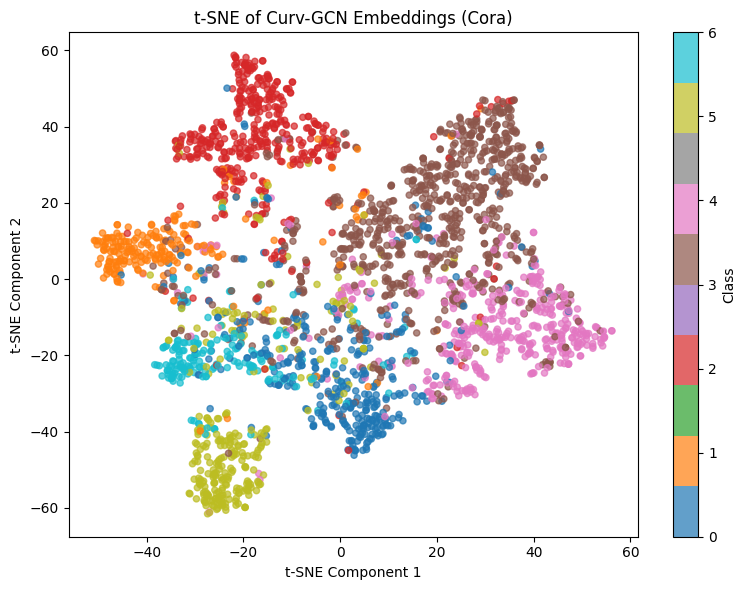

In [40]:
cora_dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
cora_data = cora_dataset[0]
data_curv = add_forman_edge_weights(cora_data.clone()).to(device)

if hasattr(data_curv, 'edge_weight'):
    print(f"  • edge_weight shape: {data_curv.edge_weight.shape}")
    print(f"  • edge_weight range: [{data_curv.edge_weight.min().item():.3f}, {data_curv.edge_weight.max().item():.3f}]")
else:
    print(f" Warning: edge_weight not found, using uniform weights")
    data_curv.edge_weight = torch.ones(data_curv.edge_index.shape[1], device=device)

model_final = GCN(data_curv.num_features, 64, cora_dataset.num_classes, use_edge_weight=True).to(device)
optimizer = torch.optim.Adam(model_final.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
train_model(model_final, data_curv, optimizer, criterion)


model_final.eval()
with torch.no_grad():
    logits = model_final(data_curv.x, data_curv.edge_index, data_curv.edge_weight)
    emb = logits.cpu().numpy()
    labels = data_curv.y.cpu().numpy()


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(emb)-1))
z = tsne.fit_transform(emb)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', s=20, alpha=0.7)
plt.title("t-SNE of Curv-GCN Embeddings (Cora)")
plt.colorbar(scatter, label='Class')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()


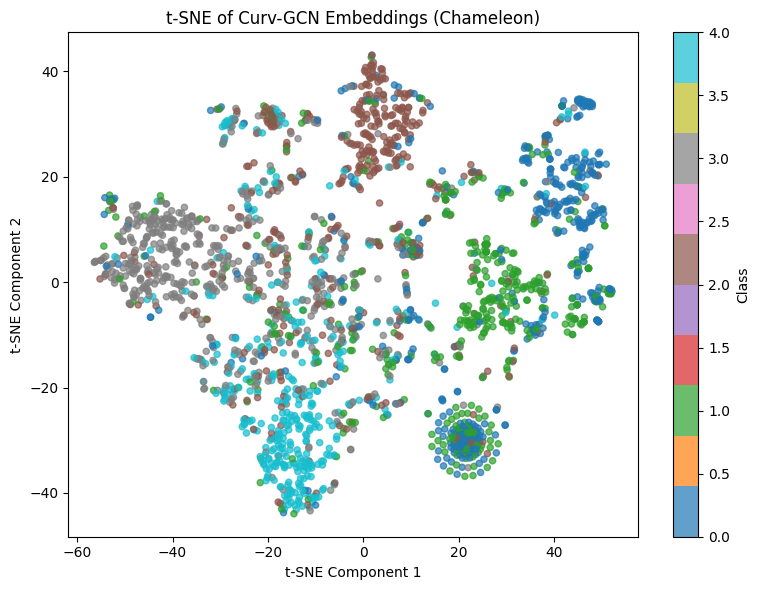

In [41]:

from torch_geometric.datasets import WikipediaNetwork

cham_dataset = WikipediaNetwork(root='/tmp/Chameleon', name='chameleon', transform=NormalizeFeatures())
cham_data = cham_dataset[0]


if cham_data.train_mask.dim() == 2:
    split_idx = 0
    cham_data.train_mask = cham_data.train_mask[:, split_idx]
    cham_data.val_mask = cham_data.val_mask[:, split_idx]
    cham_data.test_mask = cham_data.test_mask[:, split_idx]


data_curv = add_forman_edge_weights(cham_data.clone()).to(device)
model_final = GCN(data_curv.num_features, 64, cham_dataset.num_classes, use_edge_weight=True).to(device)
optimizer = torch.optim.Adam(model_final.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
train_model(model_final, data_curv, optimizer, criterion)


model_final.eval()
with torch.no_grad():
    logits = model_final(data_curv.x, data_curv.edge_index, data_curv.edge_weight)
    emb = logits.cpu().numpy()
    labels = data_curv.y.cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(emb)-1))
z = tsne.fit_transform(emb)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', s=20, alpha=0.7)
plt.title("t-SNE of Curv-GCN Embeddings (Chameleon)")
plt.colorbar(scatter, label='Class')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()


### Experiment 2 : Learnable Curvature-Aware Message Passing

In [42]:
!pip install torch_geometric -q
def add_forman_curvature_as_feature(data):
    G = to_networkx(data, to_undirected=True)
    forman = forman_curvature(G)
    edges = data.edge_index.t().tolist()
    curvature_vals = []
    for e in edges:
        key = tuple(sorted(e))
        curvature_vals.append(forman.get(key, 0.0))
    curvature_tensor = torch.tensor(curvature_vals, dtype=torch.float).unsqueeze(1)  # [E, 1]

    c_min = curvature_tensor.min()
    c_max = curvature_tensor.max()
    if c_max > c_min:
        curvature_tensor = (curvature_tensor - c_min) / (c_max - c_min)
    else:
        curvature_tensor = torch.zeros_like(curvature_tensor)

    data.edge_curvature = curvature_tensor
    return data

In [43]:
class LearnableCurvGCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.curv_mlp = torch.nn.Sequential(
            torch.nn.Linear(1, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )
    def forward(self, x, edge_index, edge_curvature):

        edge_weight = self.curv_mlp(edge_curvature).squeeze(-1)
        edge_weight = 0.1 + 0.9 * edge_weight
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x


In [44]:
class VanillaGCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index, edge_curvature=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [45]:

def train_and_evaluate(model, data, optimizer, criterion, epochs=200):
    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        if isinstance(model, LearnableCurvGCN):
            out = model(data.x, data.edge_index, data.edge_curvature)
        else:
            out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        if isinstance(model, LearnableCurvGCN):
            out = model(data.x, data.edge_index, data.edge_curvature)
        else:
            out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return test_acc


In [46]:

def run_experiment_2(dataset_name, data, num_classes, num_runs=5):
    results = {
        'vanilla_gcn': [],
        'fixed_curv_gcn': [],
        'learnable_curv_gcn': []
    }

    for run in range(num_runs):
        print(f"[{dataset_name}] Run {run+1}/{num_runs}")

        # vvanilla GCN
        model = VanillaGCN(data.num_features, 64, num_classes).to(device)
        data_d = data.to(device)
        opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        crit = torch.nn.CrossEntropyLoss()
        acc = train_and_evaluate(model, data_d, opt, crit)
        results['vanilla_gcn'].append(acc)

        # fixed Curvature GCN
        data_fixed = add_forman_curvature_as_feature(data.clone())
        curv = data_fixed.edge_curvature.squeeze().cpu()
        weights = (curv - curv.min()) / (curv.max() - curv.min() + 1e-9)
        weights = 0.1 + 0.9 * weights
        data_fixed.edge_weight = weights.to(device)
        data_fixed = data_fixed.to(device)

        model_fixed = VanillaGCN(data_fixed.num_features, 64, num_classes).to(device)
        opt_fixed = torch.optim.Adam(model_fixed.parameters(), lr=0.01, weight_decay=5e-4)
        def forward_fixed(x, edge_index, _=None):
            x = model_fixed.conv1(x, edge_index, data_fixed.edge_weight)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=model_fixed.training)
            x = model_fixed.conv2(x, edge_index, data_fixed.edge_weight)
            return x
        model_fixed.forward = forward_fixed

        model_fixed.train()
        for _ in range(200):
            opt_fixed.zero_grad()
            out = model_fixed(data_fixed.x, data_fixed.edge_index)
            loss = crit(out[data_fixed.train_mask], data_fixed.y[data_fixed.train_mask])
            loss.backward()
            opt_fixed.step()

        model_fixed.eval()
        with torch.no_grad():
            out = model_fixed(data_fixed.x, data_fixed.edge_index)
            pred = out.argmax(dim=1)
            acc_fixed = (pred[data_fixed.test_mask] == data_fixed.y[data_fixed.test_mask]).sum().item() / data_fixed.test_mask.sum().item()
        results['fixed_curv_gcn'].append(acc_fixed)

        #learnable Curvature GCN
        data_learn = add_forman_curvature_as_feature(data.clone())
        data_learn.edge_curvature = data_learn.edge_curvature.detach().to(device)
        data_learn = data_learn.to(device)

        model_learn = LearnableCurvGCN(data_learn.num_features, 64, num_classes).to(device)
        opt_learn = torch.optim.Adam(model_learn.parameters(), lr=0.01, weight_decay=5e-4)
        acc_learn = train_and_evaluate(model_learn, data_learn, opt_learn, crit)
        results['learnable_curv_gcn'].append(acc_learn)

    for key in results:
        mean, std = np.mean(results[key]), np.std(results[key])
        print(f"{key:20s}: {mean:.4f} ± {std:.4f}")
    print()
    return results

print("test on Chameleon")
dataset = WikipediaNetwork(root='/tmp/Chameleon', name='chameleon', transform=NormalizeFeatures())
data = dataset[0]


num_classes = int(data.y.max().item()) + 1
print(f"Detected {num_classes} classes from labels.")


for key in ['train_mask', 'val_mask', 'test_mask']:
    if hasattr(data, key):
        delattr(data, key)

n = data.num_nodes
idx = torch.randperm(n)
train_idx = idx[:int(0.6 * n)]
val_idx = idx[int(0.6 * n):int(0.8 * n)]
test_idx = idx[int(0.8 * n):]

data.train_mask = torch.zeros(n, dtype=torch.bool)
data.val_mask = torch.zeros(n, dtype=torch.bool)
data.test_mask = torch.zeros(n, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

assert data.train_mask.dim() == 1, f"train_mask is {data.train_mask.shape}"
assert data.y.dim() == 1, f"y is {data.y.shape}"

cham_exp2 = run_experiment_2("Chameleon", data, num_classes)

test on Chameleon
Detected 5 classes from labels.
[Chameleon] Run 1/5
[Chameleon] Run 2/5
[Chameleon] Run 3/5
[Chameleon] Run 4/5
[Chameleon] Run 5/5
vanilla_gcn         : 0.3189 ± 0.0058
fixed_curv_gcn      : 0.3882 ± 0.0020
learnable_curv_gcn  : 0.4009 ± 0.0059



In [50]:

print("test on Cora")
cora = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = cora_dataset[0]


num_classes = int(data.y.max().item()) + 1
print(f"Detected {num_classes} classes from labels.")


for key in ['train_mask', 'val_mask', 'test_mask']:
    if hasattr(data, key):
        delattr(data, key)

n = data.num_nodes
idx = torch.randperm(n)
train_idx = idx[:int(0.6 * n)]
val_idx = idx[int(0.6 * n):int(0.8 * n)]
test_idx = idx[int(0.8 * n):]

data.train_mask = torch.zeros(n, dtype=torch.bool)
data.val_mask = torch.zeros(n, dtype=torch.bool)
data.test_mask = torch.zeros(n, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

assert data.train_mask.dim() == 1, f"train_mask is {data.train_mask.shape}"
assert data.y.dim() == 1, f"y is {data.y.shape}"

cham_exp2 = run_experiment_2("Cora", data, num_classes)

test on Cora
Detected 7 classes from labels.
[Cora] Run 1/5
[Cora] Run 2/5
[Cora] Run 3/5
[Cora] Run 4/5
[Cora] Run 5/5
vanilla_gcn         : 0.8941 ± 0.0043
fixed_curv_gcn      : 0.8661 ± 0.0030
learnable_curv_gcn  : 0.8815 ± 0.0027



### Experiment 3 : Curvature Gated GCN

In [ ]:
def get_edge_curvature_tensor(data):
    G = nx.Graph()
    edge_index = data.edge_index.cpu().numpy()
    G.add_edges_from(zip(edge_index[0], edge_index[1]))
    forman = forman_curvature(G)

    curv_vals = []
    for i in range(data.edge_index.shape[1]):
        u, v = edge_index[0, i], edge_index[1, i]
        key = tuple(sorted((int(u), int(v))))
        val = forman.get(key, 0.0)
        curv_vals.append(val)

    return torch.tensor(curv_vals, dtype=torch.float, device=device)

In [ ]:
class HeteroConv(MessagePassing):

    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x_i, x_j, edge_weight):

        diff = torch.abs(x_i - x_j)
        if edge_weight is not None:
            return edge_weight.view(-1, 1) * self.lin(diff)
        return self.lin(diff)

In [ ]:
class CurvatureGatedGCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        # homophilic path
        self.homo_conv1 = GCNConv(in_dim, hidden_dim)
        self.homo_conv2 = GCNConv(hidden_dim, out_dim)

        # heterophilic path
        self.hetero_conv1 = HeteroConv(in_dim, hidden_dim)
        self.hetero_conv2 = HeteroConv(hidden_dim, out_dim)
        self.alpha = torch.nn.Parameter(torch.tensor(0.5))

    def forward(self, x, edge_index, edge_curvature):
        gate = torch.sigmoid(edge_curvature / 5.0).view(-1, 1)

        x_homo = self.homo_conv1(x, edge_index, edge_weight=gate.squeeze())
        x_homo = F.relu(x_homo)
        x_homo = F.dropout(x_homo, p=0.5, training=self.training)

        x_hetero = self.hetero_conv1(x, edge_index, edge_weight=(1 - gate).squeeze())
        x_hetero = F.relu(x_hetero)
        x_hetero = F.dropout(x_hetero, p=0.5, training=self.training)

        x = x_homo + x_hetero

        x_homo = self.homo_conv2(x, edge_index, edge_weight=gate.squeeze())
        x_hetero = self.hetero_conv2(x, edge_index, edge_weight=(1 - gate).squeeze())

        return x_homo + x_hetero


In [47]:
def train_gated_model(model, data, edge_curv, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    model.train()
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, edge_curv)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    # Eval
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, edge_curv)
        pred = out.argmax(dim=1)
        acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return acc



In [48]:

def run_gated_experiment(dataset_name, dataset_class, name):
    print(f"Running Curvature-Gated GCN on {dataset_name}")
    dataset = dataset_class(root=f'/tmp/{name}', name=name, transform=NormalizeFeatures())
    data = dataset[0].to(device)

    if data.train_mask.dim() == 2:
        data.train_mask = data.train_mask[:, 0]
        data.val_mask = data.val_mask[:, 0]
        data.test_mask = data.test_mask[:, 0]

    edge_curv = get_edge_curvature_tensor(data)
    print(f"Curvature Range: [{edge_curv.min():.2f}, {edge_curv.max():.2f}]")

    model = CurvatureGatedGCN(data.num_features, 64, dataset.num_classes).to(device)
    test_acc = train_gated_model(model, data, edge_curv, epochs=200)

    print(f"{dataset_name} test accuracy: {test_acc:.4f}")
    return test_acc

acc_cora = run_gated_experiment("Cora", Planetoid, "Cora")

acc_cham = run_gated_experiment("Chameleon", WikipediaNetwork, "chameleon")

Running Curvature-Gated GCN on Cora
Curvature Range: [0.00, 6.00]
Cora test accuracy: 0.7010
Running Curvature-Gated GCN on Chameleon


Processing...
Done!


Curvature Range: [0.00, 652.00]
Chameleon test accuracy: 0.4518
